In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from warnings import filterwarnings
from tqdm import tqdm
import statsmodels.api as sm
sns.set_style("white")
filterwarnings('ignore')

# The Data Class
    """
    A class used to represent Dengue Data

    ...

    Attributes
    ----------
    features : pandas.DataFrame
        uses a multi-Index for city, and week as a DateTimeIndex with weekly frequency
    labels : pandas.DataFrame
        uses a multi-Index for city, and week as a DateTimeIndex. contains single columns for total_cases
    n_features : int
        number of features
    n_samples : int
        the number samples

    Methods
    -------
    impute_missing(method=KNN, add_indicator=False)
        Imputes missing values.

    split_train_test(self, inplace=False, append_labels=False, intercept=False, x=None, y=None, city=None,  test_setsz=.2)
        returns features_train, labels_train, features_test, labels_test.

    principle_components(self, n_pc, city=None, plotting=True):
        performs PCA on the features for dimensionality reduction. (reduce bias)

    plot_cases
        plots cases over time in both cities
    plot_case_dist
        plots the distribution of cases in both cities
    """


In [3]:
class DengueData:
    """
    A class used to represent Dengue Data

    ...

    Attributes
    ----------
    features : pandas.DataFrame
        uses a multi-Index for city, and week as a DateTimeIndex with weekly frequency
    labels : pandas.DataFrame
        uses a multi-Index for city, and week as a DateTimeIndex. contains single columns for total_cases
    n_features : int
        number of features
    n_samples : int
        the number samples

    Methods
    -------
    impute_missing(method=KNN, add_indicator=False)
        Imputes missing values.

    split_train_test(self, inplace=False, append_labels=False, intercept=False, x=None, y=None, city=None,  test_setsz=.2)
        returns features_train, labels_train, features_test, labels_test.

    principle_components(self, n_pc, city=None, plotting=True):
        performs PCA on the features for dimensionality reduction. (reduce bias)

    plot_cases()
    plot_case_dist
    """

    def __init__(self, impute=None, test_setsz=.2):

        features = pd.read_csv('../Data/dengue_features_train.csv')
        features.index = pd.DatetimeIndex(features.week_start_date)#.to_period("w")
        features.index = pd.MultiIndex.from_tuples(list(zip(*[features.city, features.index])), names=['city', 'week_start_date'])
        self.features = features[features.columns[4:]]
        self.labels = pd.read_csv('../Data/dengue_labels_train.csv', index_col=[0, 1, 2])
        self.labels.index = features.index
        self.n_features, self.n_samples = self.features.shape
        self.feat_train, self.labels_train, self.feat_test, self.labels_test = [None] * 4
        if impute is not None:
            self.impute_missing(method=impute)

    def impute_missing(self, method, add_indicator=False):
        '''
        Method for imputting missing data

        :param add_indicator:
        :param method: str; how to impute missing values
            pad / ffill: propagate last valid observation forward to next valid
            backfill / bfill: use next valid observation to fill gap.
            mean: fill with the mean value of the feature
            median: fill with median value of the feature
            KNN: optimized K-nearest neighbors
        :return:
        '''
        if add_indicator:
                self.features = self.features.join(self.features.isna().astype(float), rsuffix='_miss')
        if method in ['backfill', 'bfill', 'pad', 'ffill']:
            self.features.fillna(method=method, inplace=True)
        if method == 'mean':
            self.features.fillna(value=self.features.mean(axis=0), inplace=True)
        if method == 'median':
            self.features.fillna(value=self.features.median(axis=0), inplace=True)
        if method == 'linear':
            self.features.interpolate(method='linear', axis=0, inplace=True)
        if method == 'time':
            X = self.features
            idx = X.index
            X.reset_index(drop=True, inplace=True)
            X.index=idx.get_level_values('week_start_date')
            X.interpolate(method='time', axis=0, inplace=True)
            X.index = idx
            self.features = X

        if method in ['quadratic', 'cubic']:
            X = self.features
            idx = X.index
            X.reset_index(drop=True, inplace=True)
            X.interpolate(method=method, axis=0, inplace=True)
            X.index = idx
            self.features = X

        if method == 'KNN':
            rmse = lambda actual, yhat: np.sqrt(mean_squared_error(actual, yhat))
            errors = {'K':[], 'RMSE':[]}
            for k in range(1, 20, 2):
                imputer = KNNImputer(n_neighbors=k, weights='distance')
                imputed = pd.DataFrame(imputer.fit_transform(self.features))
                feat_train, labels_train, feat_test, labels_test = self.split_train_test(x=imputed)
                model = RandomForestRegressor()
                model.fit(feat_train, labels_train.to_numpy().ravel())
                preds = model.predict(feat_test)
                error = rmse(labels_test, preds)
                errors['K'].append(k)
                errors['RMSE'].append(error)
            df_k = pd.DataFrame(errors)
            k = int(df_k.loc[df_k['RMSE'].idxmin()]['K'])
            imputer = KNNImputer(n_neighbors=k, weights='distance')
            self.features =  pd.DataFrame(imputer.fit_transform(self.features), columns = list(self.features.columns), index=self.features.index)

    def split_train_test(self, inplace=False, append_labels=False, intercept=False, x=None, y=None, city=None,  test_setsz=.2):
        '''
        splits features into training and test sets.
        '''

        if x is None:
            x = self.features
        if y is None:
            y = self.labels
        if intercept:
            x.insert(loc=0, column="Intercept", value=1)

        if city is not None:
            x = x.loc[city]
            y = y.loc[city]

        feat_train = x.iloc[:int(np.floor(len(x) * (1 - test_setsz)))]
        feat_test = x.iloc[:int(np.floor(len(x) * test_setsz))]

        labels_train = y.iloc[:int(np.floor(len(y) * (1 - test_setsz)))]
        labels_test = y.iloc[:int(np.floor(len(y) * test_setsz))]

        if append_labels:
            feat_train['total_cases'] = labels_train.total_cases.values
            feat_test['total_cases'] = labels_test.total_cases.values

        if inplace:
            self.feat_train, self.labels_train, self.feat_test, self.labels_test = [feat_train, labels_train, feat_test, labels_test]
            return
        else:
            return feat_train, labels_train, feat_test, labels_test

    def plot_case_dist(self):
        sns.displot(x='total_cases', col='city', data=self.labels);
        pass

    def plot_cases(self):
        sns.relplot(x=self.features.index.get_level_values(1), y=self.labels.total_cases, col=self.features.index.get_level_values(0), kind='line');

    def principle_components(self, n_pc, city=None, plotting=True):
        if city is not None:
            xx = self.features.loc[city]
        else:
            xx = self.features
        X_scaled = StandardScaler().fit_transform(xx)


        pc_list = ["PC"+str(i) for i in list(range(1, n_pc+1))]
        # Decompose
        pca = PCA(n_components=n_pc)
        self.feat_pc = pd.DataFrame(data=pca.fit_transform(X_scaled), columns=pc_list, index=xx.index)
        #finalDf = pd.concat([self.feat_pc, pd.Series(Y.total_cases.values, name='total_cases')], axis=1)
        skree_df = pd.DataFrame({'unexplained variance': pca.explained_variance_ratio_, 'PC':pc_list})
        total_var_exp = np.cumsum(pca.explained_variance_ratio_)

        # Attribute loadings onto PCs
        loadings = pca.components_
        #num_pc = pca.n_features_
        loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, abs(loadings))))
        loadings_df['variable'] = self.features.columns
        loadings_df.set_index('variable', inplace=True)
        loadings_df.sort_values(pc_list, ascending=False, inplace=True)
        if plotting:
            f, ax = plt.subplots(figsize=(20, 7), ncols=2)
            sns.pointplot(x='PC', y="unexplained variance", data=skree_df, color="c", ax=ax[1])
            sns.heatmap(loadings_df, ax=ax[0])
            ax[0].set_title("Loading")
            ax[1].set_title("Skree - Unexplained Variance")


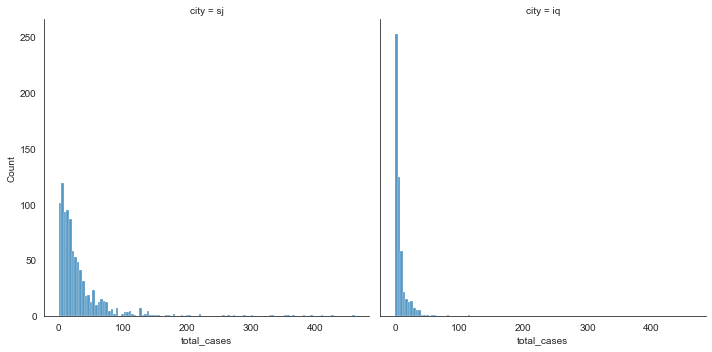

In [5]:
dat = DengueData()
dat.plot_case_dist()

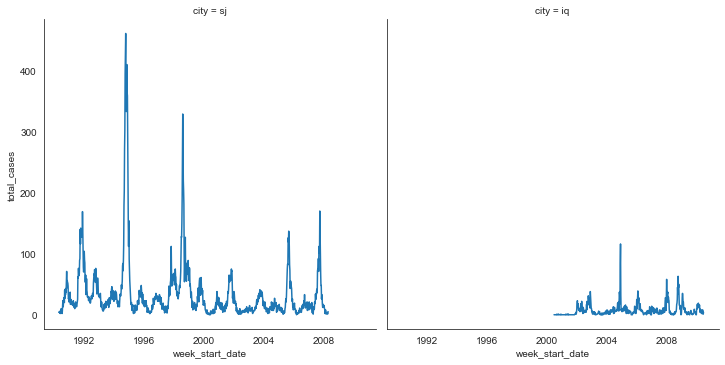

In [6]:
dat.plot_cases()

# Negative Binomial
## All features - multiple methods for imputation

In [7]:

for mtd in ['mean', 'median','linear','quadratic', 'cubic', 'time', 'bfill', 'ffill', 'KNN']:
    errs = []
    for cc in ['sj', 'iq']:
        dat = DengueData(impute=mtd)
        feat_train, labels_train, feat_test, labels_test = dat.split_train_test(city=cc, intercept=True)
        formula = 'total_cases ~ + 1 '+" ".join(['+ '+v for v in feat_train.columns])
        nb_train_result = sm.GLM(endog=labels_train , exog=feat_train, family=sm.families.NegativeBinomial(alpha=1)).fit()
        test_preds = nb_train_result.get_prediction(feat_test).predicted_mean
        errs.append(abs(labels_test.total_cases - test_preds))
    print(f'imput method: {mtd}, error: {errs[0].append(errs[1]).mean()}')



imput method: mean, error: 19.044282658935586
imput method: median, error: 18.690662151615673
imput method: linear, error: 17.71938222450332
imput method: quadratic, error: 16.407849043805594
imput method: cubic, error: 16.382726510481238
imput method: time, error: 17.70061530996223
imput method: bfill, error: 18.31706072520119
imput method: ffill, error: 17.186355125778164
imput method: KNN, error: 18.71160807245806


## Principle Components

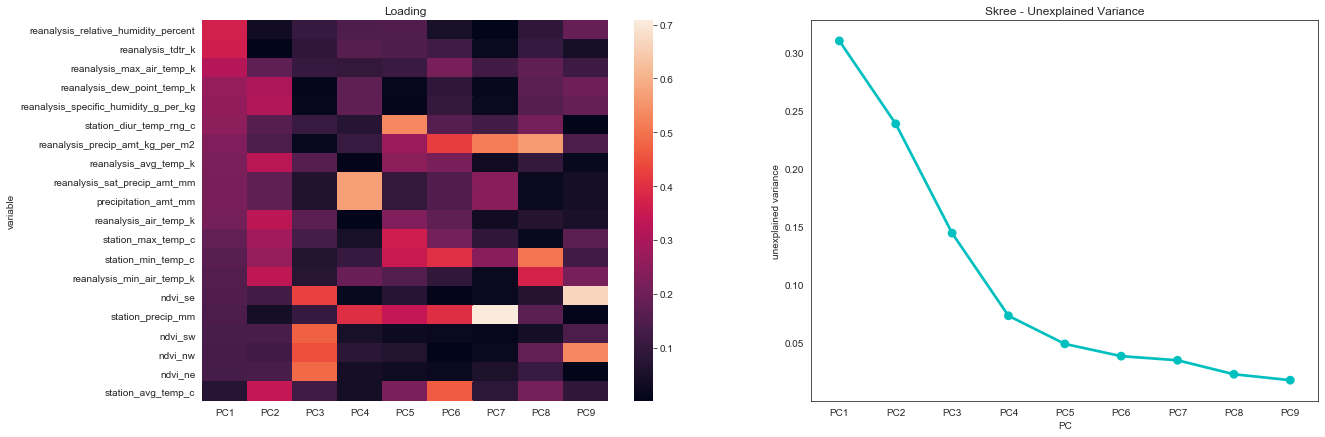

In [8]:
dat = DengueData(impute='cubic')
dat.principle_components(n_pc=9, city='iq')

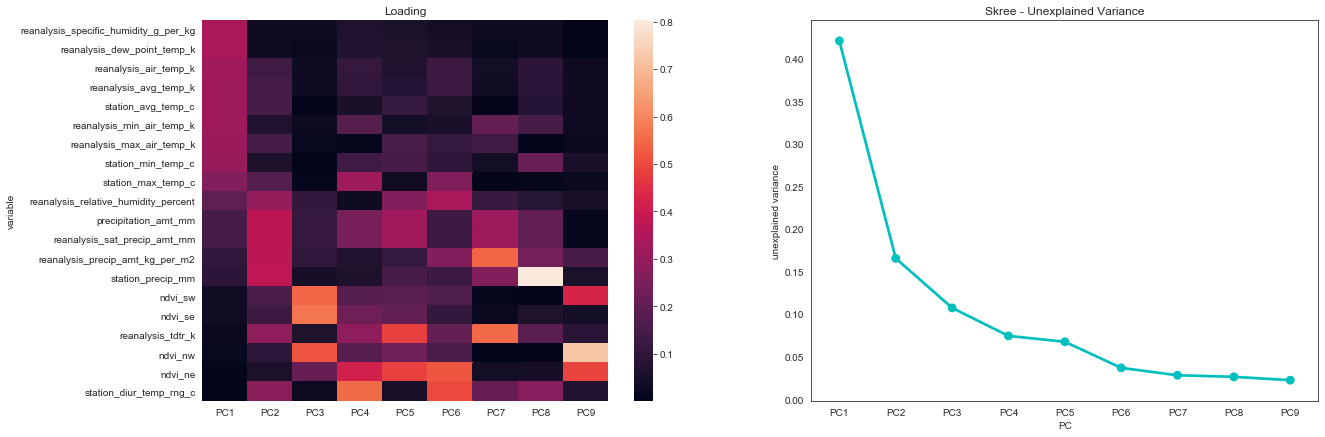

In [9]:
dat = DengueData(impute='cubic')
dat.principle_components(n_pc=9, city='sj')

In [10]:
for mtd in ['mean', 'median','linear','quadratic', 'cubic', 'time', 'bfill', 'ffill', 'KNN']:
    errs = []
    for cc, npc in zip(['sj', 'iq'], [4, 5]):
        dat = DengueData(impute=mtd)
        dat.principle_components(n_pc=npc, city=cc, plotting=False)
        pc_x_train, pc_y_train, pc_x_test, pc_y_test = dat.split_train_test(x=dat.feat_pc, y=dat.labels.loc[cc], intercept=True)
        formula = 'total_cases ~ + 1 '+" ".join(['+ '+v for v in pc_x_train.columns])
        nb_train_result = sm.GLM(endog=pc_y_train , exog=pc_x_train, family=sm.families.NegativeBinomial(alpha=1)).fit()
        test_preds = nb_train_result.get_prediction(pc_x_test).predicted_mean
        errs.append(abs(pc_y_test.total_cases - test_preds))
    print(f'imput method: {mtd}, error: {errs[0].append(errs[1]).mean()}')


imput method: mean, error: 17.902578128719703
imput method: median, error: 17.781934623826874
imput method: linear, error: 17.640235331082394
imput method: quadratic, error: 16.465242723962227
imput method: cubic, error: 16.417655403476406
imput method: time, error: 17.087761257253376
imput method: bfill, error: 18.150990878922947
imput method: ffill, error: 17.193141872588086
imput method: KNN, error: 17.422256178003813


# AR models

In [11]:
dat = DengueData(impute='cubic')

x_train, y_train, x_test, y_test = dat.split_train_test(city='sj', intercept=True)


## Testing for stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

result = adfuller(y_train['total_cases'])
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
for value,label in zip(result,labels):
    print(label+' : '+str(value) )
if result[1] <= 0.05:
    print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

ADF Test Statistic : -4.914390459100147
p-value : 3.269348022161414e-05
#Lags Used : 12
Number of Observations Used : 735
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


## ARMA

In [28]:
#for p in range(1,5):
#    for q in range(1, 5):
errs = []
for cc in ['sj', 'iq']:
    dat = DengueData(impute='ffill')
    x_train, y_train, x_test, y_test = dat.split_train_test(city=cc, intercept=True)
    for df in [x_train, y_train, x_test, y_test]:
        df.reset_index(inplace=True)
        df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
        df.drop('week_start_date', inplace=True, axis=1)
    ARMAmodel = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, order=(3, 0, 1))
    res = ARMAmodel.fit()
    # generating predictions
    y_pred = res.predict(start=x_test.index[0], end=x_test.index[-1], exog=x_test)
    errs.append(abs(y_pred.values - y_test.total_cases.values))

print(f'ARMA method, p={3}, q={1} error: {np.concatenate(errs).mean()}')


ARMA method, p=3, q=1 error: 10.352161157484009


## ARMA ON PCS?

In [43]:
for mtd in [ 'cubic', 'time', 'bfill', 'ffill']:
    errs = []
    for cc, npc in zip(['sj', 'iq'], [4, 5]):
        dat = DengueData(impute=mtd)
        dat.principle_components(n_pc=npc, city=cc, plotting=False)
        pc_x_train, pc_y_train, pc_x_test, pc_y_test = dat.split_train_test(x=dat.feat_pc, y=dat.labels.loc[cc], intercept=True)
        for df in [pc_x_train, pc_y_train, pc_x_test, pc_y_test]:
            df.reset_index(inplace=True)
            df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
            df.drop('week_start_date', inplace=True, axis=1)
        ARMAmodel = sm.tsa.statespace.SARIMAX(endog=pc_y_train, exog=pc_x_train, order=(3, 0, 1))
        res = ARMAmodel.fit()
        # generating predictions
        y_pred = res.predict(start=pc_x_test.index[0], end=pc_x_test.index[-1], exog=pc_x_test)
        #preds.append(y_pred)#y_pred = res.predict(start=pc_y_test.index[0], end=pc_y_test.index[-1])
        errs.append(abs(y_pred.values - pc_y_test.total_cases.values))

    print(f'imput method: {mtd}, error: {np.concatenate(errs).mean()}')


imput method: cubic, error: 5.890840395195335
imput method: time, error: 5.886081407106493
imput method: bfill, error: 5.895893932593429
imput method: ffill, error: 5.893271118846024


In [44]:
pc_x_test

,Intercept,PC1,PC2,PC3,PC4,PC5
week_start_date,,,,,,
2000-06-26/2000-07-02,1,-0.047956,2.023608,0.288683,-1.417502,-0.045235
2000-07-03/2000-07-09,1,0.085053,1.247859,-0.418199,0.196053,0.854021
2000-07-10/2000-07-16,1,-1.903534,2.129013,1.114706,-0.479260,1.148411
2000-07-17/2000-07-23,1,1.056764,7.296102,-0.553217,-0.238385,1.943194
2000-07-24/2000-07-30,1,1.219041,2.312579,-2.006842,0.317541,1.481090
...,...,...,...,...,...,...
2002-05-27/2002-06-02,1,-1.702499,1.553383,0.658888,-0.447519,-1.032569
2002-06-03/2002-06-09,1,-0.278558,1.249634,-1.552427,0.207548,1.647826
2002-06-10/2002-06-16,1,0.136748,-0.715747,-2.020058,-0.597446,1.107071


In [51]:

# Predicting real Test set for PC model
preds = []
for cc, npc in zip(['sj', 'iq'], [4, 5]):
    dat = DengueData(impute='time')
    dat.principle_components(n_pc=npc, city=cc, plotting=False)
    pc_x_train, pc_y_train, pc_x_test, pc_y_test = dat.split_train_test(x=dat.feat_pc, y=dat.labels.loc[cc],intercept=True, test_setsz=0.01)


    x_test = pd.read_csv('../Data/dengue_features_test.csv', index_col=[0, 1, 2])
    #idx = x_test.index
    #x_test.reset_index(drop=True, inplace=True)
    #x_test.index=idx.get_level_values('week_start_date')
    #x_test.interpolate(method='time', axis=0, inplace=True)
    #x_test.index = idx
    x_test = x_test.loc[cc]
    #x_test.drop('week_start_date', inplace=True, axis=1)

    for df in [pc_x_train, pc_y_train, x_test]:
        df.reset_index(inplace=True)
        df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
        df.drop('week_start_date', inplace=True, axis=1)
    wk = x_test[['year', 'weekofyear']]
    x_test.drop(['year', 'weekofyear'], axis=1, inplace=True)
    x_test.interpolate(method='time', axis=0, inplace=True)

    # Decompose
    X_scaled = StandardScaler().fit_transform(x_test)
    pc_list = ["PC"+str(i) for i in list(range(1, npc+1))]
    pca = PCA(n_components=npc)
    x_test = pd.DataFrame(data=pca.fit_transform(X_scaled), columns=pc_list, index=x_test.index)

    x_test.insert(loc=0, column="Intercept", value=1)
    #x_test.index = pc_x_train.index
    ARMAmodel = sm.tsa.statespace.SARIMAX(endog=pc_y_train, exog=pc_x_train,  order=(3, 0, 1))
    res = ARMAmodel.fit()
    # generating predictions
    y_pred = res.predict(start=x_test.index[0], end=x_test.index[-1], exog=x_test)
    #y_pred = res.forecast(steps=len(x_test), exog=x_test)  #res.predict(start=x_test.index[0], end=x_test.index[-1], exog=x_test)
    preds.append(y_pred)

ValueError: Provided exogenous values are not of the appropriate shape. Required (274, 5), got (260, 5).

In [50]:
x_test

,PC1,PC2,PC3,PC4
week_start_date,,,,
2008-04-28/2008-05-04,0.659320,1.821491,2.125230,2.561208
2008-05-05/2008-05-11,2.163652,1.090074,1.539748,-0.734797
2008-05-12/2008-05-18,0.216376,-2.693807,2.669863,2.729323
2008-05-19/2008-05-25,0.050993,-3.154508,2.129204,1.421291
2008-05-26/2008-06-01,-0.037438,-1.289232,2.505009,1.762420
...,...,...,...,...
2013-03-25/2013-03-31,0.725806,-1.267843,2.390838,2.125576
2013-04-01/2013-04-07,1.487845,-0.176690,1.022018,0.161646
2013-04-08/2013-04-14,0.478225,-2.451181,1.357449,1.200644


In [52]:
# Predicting real Test set AR model
preds = []
for cc in ['sj', 'iq']:
    dat = DengueData(impute='ffill')
    #x_train = dat.features
    #y_train = dat.labels
    x_train, y_train, x_test, y_test = dat.split_train_test(city=cc, intercept=True, test_setsz=0)

    x_test = pd.read_csv('../Data/dengue_features_test.csv', index_col=[0, 1, 2])

    x_test = x_test.loc[cc]

    for df in [x_train, y_train, x_test]:
        df.reset_index(inplace=True)
        df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
        df.drop('week_start_date', inplace=True, axis=1)
    wk = x_test[['year', 'weekofyear']]
    x_test.drop(['year', 'weekofyear'], axis=1, inplace=True)
    x_test.fillna(method='ffill', inplace=True)
    x_test.insert(loc=0, column="Intercept", value=1)

    ARMAmodel = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train,  order=(3, 0, 1))
    res = ARMAmodel.fit()
    # generating predictions
    y_pred = res.forecast(steps=len(x_test), exog=x_test)  #res.predict(start=x_test.index[0], end=x_test.index[-1], exog=x_test)
    preds.append(y_pred)

In [53]:
#np.concatenate(errs)
#errs[1].shape
def make_submission(preds, filename):
    """
    preds is a list of length 2, (one for each city) of pandas Series.
    Each series contains the output of the prediction
    """
    x_test = pd.read_csv('../Data/dengue_features_test.csv', index_col=[0, 1, 2])
    xx = preds[0].append(preds[1])
    xx.reset_index(drop=True, inplace=True)
    xx.index = x_test.index
    xx = pd.DataFrame(xx)
    xx.rename(columns={'predicted_mean': 'total_cases'}, inplace=True)
    xx.total_cases = [int(round(tc)) for tc in xx.total_cases]
    xx.to_csv('../Data/'+filename, sep=',')
    return


make_submission(preds, 'BG_submission2.csv')


# K- Fold Cross Validation

In [4]:
dat = DengueData(impute='time')

In [49]:
param_df = pd.DataFrame(columns=dat.features.columns)
feat = dat.features.loc['sj']
lab = dat.labels.loc['sj']
errs = []
K = 20
for fold in tqdm(range(1, K+1)):
    feat_train = feat[:-K]
    feat_test = feat[-K:]
    lab_train = lab[:-K]
    lab_test = lab[-K:]
    for df in [feat_train, lab_train, feat_test, lab_test]:
        df.reset_index(inplace=True)
        df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
        df.drop('week_start_date', inplace=True, axis=1)
    ARMAmodel = sm.tsa.statespace.SARIMAX(endog=lab_train, exog=feat_train, order=(3, 0, 1))
    res = ARMAmodel.fit()
    param_df = param_df.append(res.params, ignore_index=True)
    # generating predictions
    #y_pred = res.predict(start=feat_test.index[0], end=feat_test.index[-1], exog=feat_test)
    # generating predictions
    y_pred = res.forecast(steps=len(feat_test), exog=feat_test)
    errs.append(lab_test.total_cases.values - y_pred.values)
    feat = feat.iloc[np.arange(-K, len(feat)-1)]
    lab = lab.iloc[np.arange(-K, len(lab)-1)]

    #preds.append(y_pred)

100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


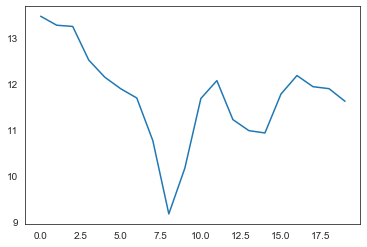

In [67]:
param_df.reanalysis_relative_humidity_percent.plot()

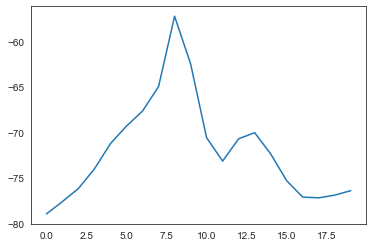

In [54]:
param_df.reanalysis_dew_point_temp_k.plot()